## Installing Proper Required Libraries

In [9]:
!pip install Bio
!pip install pandas
!pip install numpy
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

# download data
!wget --user=ftp ftp://ccg.epfl.ch/epd/current/epd_16K.seq

clear_output()

## Building DataFrames

In [10]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import math
import random

# Initializing lists that will contain info about each record
accessIDs = []
DNA_Sequences = []
sequence_lengths = []
parsed_subsequences = []

dna_mappings = {}
# dna_mappings['A'] = 1
# dna_mappings['C'] = 10
# dna_mappings['T'] = 100
# dna_mappings['G'] = 1000
dna_mappings['A'] = [0, 0, 0, 1]
dna_mappings['C'] = [0, 0, 1, 0]
dna_mappings['T'] = [0, 1, 0, 0]
dna_mappings['G'] = [1, 0, 0, 0]

windowed_sequence_list = []

# All DNA sequences of the human genome are 16,000 characters long (Hence epd_16K)
# if using epd_16K. If using epd_seq, then change the sequence_length variable
# to 600
sequence_length = 16000

# Loop through all records parsed by SeqIO.
#
# ") Hs" on the description line means that
# we've found a Homo sapien DNA sequence, so
# add the appropriate properties of seq_record
# to the appropriate arrays. This is our way
# to filter out non-homosapien sequences
for seq_record in SeqIO.parse('epd_16K.seq', 'fasta'):
  if seq_record.seq.find('N') == -1 and seq_record.description.find(') Hs') != -1:
    accessIDs.append(seq_record.id)
    DNA_Sequences.append(seq_record.seq)
    sequence_lengths.append(len(seq_record))

print("Number of sequences: " + str(len(DNA_Sequences)))

# Defining rows of PSFM and initializing all frequencies to 0
adenine_frequencies = np.zeros(sequence_length)
guanine_frequencies = np.zeros(sequence_length)
thymine_frequencies = np.zeros(sequence_length)
cytosine_frequencies = np.zeros(sequence_length)
other_frequency = np.zeros(sequence_length)

# Loop through all the DNA sequences in the DNA_Sequence list.
# For each sequence, check if the nucleobase (character) at 
# postition sequence_index is adenine, guanine, thymine, or cytosine.
# If it's any of those, then increment the count at that list's index.
for sequence in DNA_Sequences:

  # Randomly generating where the window begins,
  # and since we want each sequence to be 6,000 chars
  # long, we add 6,000 to the rng splicedStart, giving
  # us the spliced end. Then, since we moved the start of
  # the sequence up by a number of splicedStart, to get where
  # the promoter is in relation to that new start, we can
  # subtract splicedStart from 10,000
  # i.e. promoterindex = 10,000 - splicedStart
  splicedStart = random.randint(5000, 9000)
  splicedEnd = splicedStart + 6000
  sub_sequence = sequence[splicedStart : splicedEnd]
  promoter_index = 10000 - splicedStart

  # OneHot on subsequence string to create list of lists for features
  parsed_str = str(sub_sequence).replace('A', '1000').replace('G', '0100').replace('T', '0010').replace('C', '0001')

  encoding = []
  encoding.append(promoter_index)

  for nucleotide in sub_sequence:
    encoding.extend(dna_mappings[nucleotide])
    # if nucleotide == 'A':
    #   encoding.extend(dna_mappings['A'])
    # elif nucleotide == 'C':
    #   encoding.extend(dna_m)
    # elif nucleotide == 'G':
    #   encoding.append(100)
    # else:
    #   encoding.append(1000)
  
  windowed_sequence_list.append(tuple(encoding))

  one_hot_sequence = [int(i) for i in parsed_str]
  # one_hot_sequence = np.asarray(one_hot_sequence)
  # one_hot_sequence = np.asarray(one_hot_sequence, dtype = 'int32')
  # one_hot_sequence = pd.Series(data = one_hot_sequence)
  
  pair = (sub_sequence, promoter_index, splicedStart, splicedEnd)
  parsed_subsequences.append(pair)
  

  # Reset where the index is in the
  # sequence string
  sequence_index = 0

  for nucleobase in sequence:
    if nucleobase == 'A':
      adenine_frequencies[sequence_index] += 1
    elif nucleobase == 'G':
      guanine_frequencies[sequence_index] += 1
    elif nucleobase == 'T':
      thymine_frequencies[sequence_index] += 1
    elif nucleobase == 'C':
      cytosine_frequencies[sequence_index] += 1
    else:
      other_frequency[sequence_index] += 1

    sequence_index += 1
  
dna_df_columns = []
dna_df_columns.append('Promoter-Index')
for i in range(24000):
  dna_df_columns.append("Nuc-" + str(i))
dna_df = pd.DataFrame(windowed_sequence_list, columns = dna_df_columns)

subsequence_df = pd.DataFrame(parsed_subsequences, columns = ['Sub-Sequences', 'Promoter-Index', 'SequenceStart', 'SequenceEnd'])

# In the above loop, we calculated how many occurences M of a particular nucelobase N
# at some sequence index I. In this loop, we divide each number of occurences by the total
# number of possible occurences there could be, which would be the number of records
# because each record is guaranteed to have a nucleobase at character I in the human
# DNA sequence. I.e.
# P(sequence[i] == N) == (# of nucleobases N found at index i) / (# of possible nucleobases N at index i)
for i in range(sequence_length):
  adenine_frequencies[i] = (adenine_frequencies[i] / len(DNA_Sequences)) * 100
  guanine_frequencies[i] = (guanine_frequencies[i] / len(DNA_Sequences)) * 100
  thymine_frequencies[i] = (thymine_frequencies[i] / len(DNA_Sequences)) * 100
  cytosine_frequencies[i] = (cytosine_frequencies[i] / len(DNA_Sequences)) * 100


# Defining the series that will be fed into the pandas Data Frame, based off the lists defined above
records_df = pd.DataFrame({'IDs': accessIDs, 'Sequences': DNA_Sequences, 'Lengths': sequence_lengths},
                          columns = ['IDs', 'Sequences', 'Lengths'])

# Defining the data frame for the Position Specific Frequency Matrix (PSFM)
frequency_df = pd.DataFrame({'Adenine Frequencies': adenine_frequencies, 'Guanine Frequencies': guanine_frequencies, 'Thymine Frequencies': thymine_frequencies, 'Cytosine Frequencies': cytosine_frequencies},
                            columns = ['Adenine Frequencies', 'Guanine Frequencies', 'Thymine Frequencies', 'Cytosine Frequencies'])

Number of sequences: 1837


## Backup test dataframe

In [11]:
dna_df.head(n = 20)

,Promoter-Index,Nuc-0,Nuc-1,Nuc-2,Nuc-3,Nuc-4,Nuc-5,Nuc-6,Nuc-7,Nuc-8,Nuc-9,Nuc-10,Nuc-11,Nuc-12,Nuc-13,Nuc-14,Nuc-15,Nuc-16,Nuc-17,Nuc-18,Nuc-19,Nuc-20,Nuc-21,Nuc-22,Nuc-23,Nuc-24,Nuc-25,Nuc-26,Nuc-27,Nuc-28,Nuc-29,Nuc-30,Nuc-31,Nuc-32,Nuc-33,Nuc-34,Nuc-35,Nuc-36,Nuc-37,Nuc-38,...,Nuc-23960,Nuc-23961,Nuc-23962,Nuc-23963,Nuc-23964,Nuc-23965,Nuc-23966,Nuc-23967,Nuc-23968,Nuc-23969,Nuc-23970,Nuc-23971,Nuc-23972,Nuc-23973,Nuc-23974,Nuc-23975,Nuc-23976,Nuc-23977,Nuc-23978,Nuc-23979,Nuc-23980,Nuc-23981,Nuc-23982,Nuc-23983,Nuc-23984,Nuc-23985,Nuc-23986,Nuc-23987,Nuc-23988,Nuc-23989,Nuc-23990,Nuc-23991,Nuc-23992,Nuc-23993,Nuc-23994,Nuc-23995,Nuc-23996,Nuc-23997,Nuc-23998,Nuc-23999
0,3401,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0
1,1142,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1
2,2512,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
3,4159,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0
4,3296,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0
5,2936,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
6,3366,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
7,1653,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
8,2918,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
9,4412,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0


# RECORDS DATAFRAME INFORMATION

---



## Printing records dataframe

In [12]:
records_df.head(n=20)

,IDs,Sequences,Lengths
0,EP17030,"(G, A, G, C, C, A, T, C, C, C, G, G, G, A, G, ...",16000
1,EP17031,"(C, A, A, T, G, G, A, A, A, C, C, C, T, C, C, ...",16000
2,EP17041,"(G, G, G, G, T, T, T, C, G, C, C, A, T, G, T, ...",16000
3,EP49001,"(C, A, A, A, A, A, A, C, T, A, A, A, C, A, A, ...",16000
4,EP30042,"(T, G, A, G, T, G, G, G, C, T, A, T, G, A, G, ...",16000
5,EP11068,"(G, A, A, G, G, C, T, A, T, C, A, C, T, A, A, ...",16000
6,EP11070,"(T, G, G, T, T, T, C, A, C, A, T, G, A, G, T, ...",16000
7,EP11073,"(T, T, C, T, T, C, T, T, T, T, T, T, C, C, T, ...",16000
8,EP15024,"(G, G, C, G, T, G, G, T, G, G, C, T, C, A, C, ...",16000
9,EP49012,"(T, G, A, A, G, G, A, T, C, C, T, A, A, G, A, ...",16000


# FREQUENCY DATAFRAME INFORMATION

---




## Printing frequency data frame

In [13]:
frequency_df.head(n=10500)

,Adenine Frequencies,Guanine Frequencies,Thymine Frequencies,Cytosine Frequencies
0,27.381600,23.462167,26.292869,22.863364
1,27.544910,22.427872,27.925966,22.101252
2,28.579205,22.318998,27.544910,21.556886
3,25.367447,24.605335,26.183996,23.843223
4,26.891671,21.665759,27.925966,23.516603
...,...,...,...,...
10495,20.794774,29.613500,24.496462,25.095264
10496,23.407730,27.871530,23.571040,25.149701
10497,20.032662,30.212303,22.591181,27.163854
10498,21.829069,28.089276,23.788786,26.292869


## Describing Frequency data frame

In [14]:
frequency_df.describe()

,Adenine Frequencies,Guanine Frequencies,Thymine Frequencies,Cytosine Frequencies
count,16000.000000,16000.000000,16000.000000,16000.000000
mean,26.251453,23.675031,26.934346,23.139171
std,2.278417,2.340623,2.159434,1.966093
min,8.002177,16.276538,2.994012,18.290691
25%,25.639630,22.427872,26.238432,21.992379
50%,26.619488,23.189984,27.272727,22.808928
75%,27.544910,24.115406,28.198149,23.679913
max,44.039194,39.085465,32.716385,50.081655


## Plotting frequency graph

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd22710ecd0>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

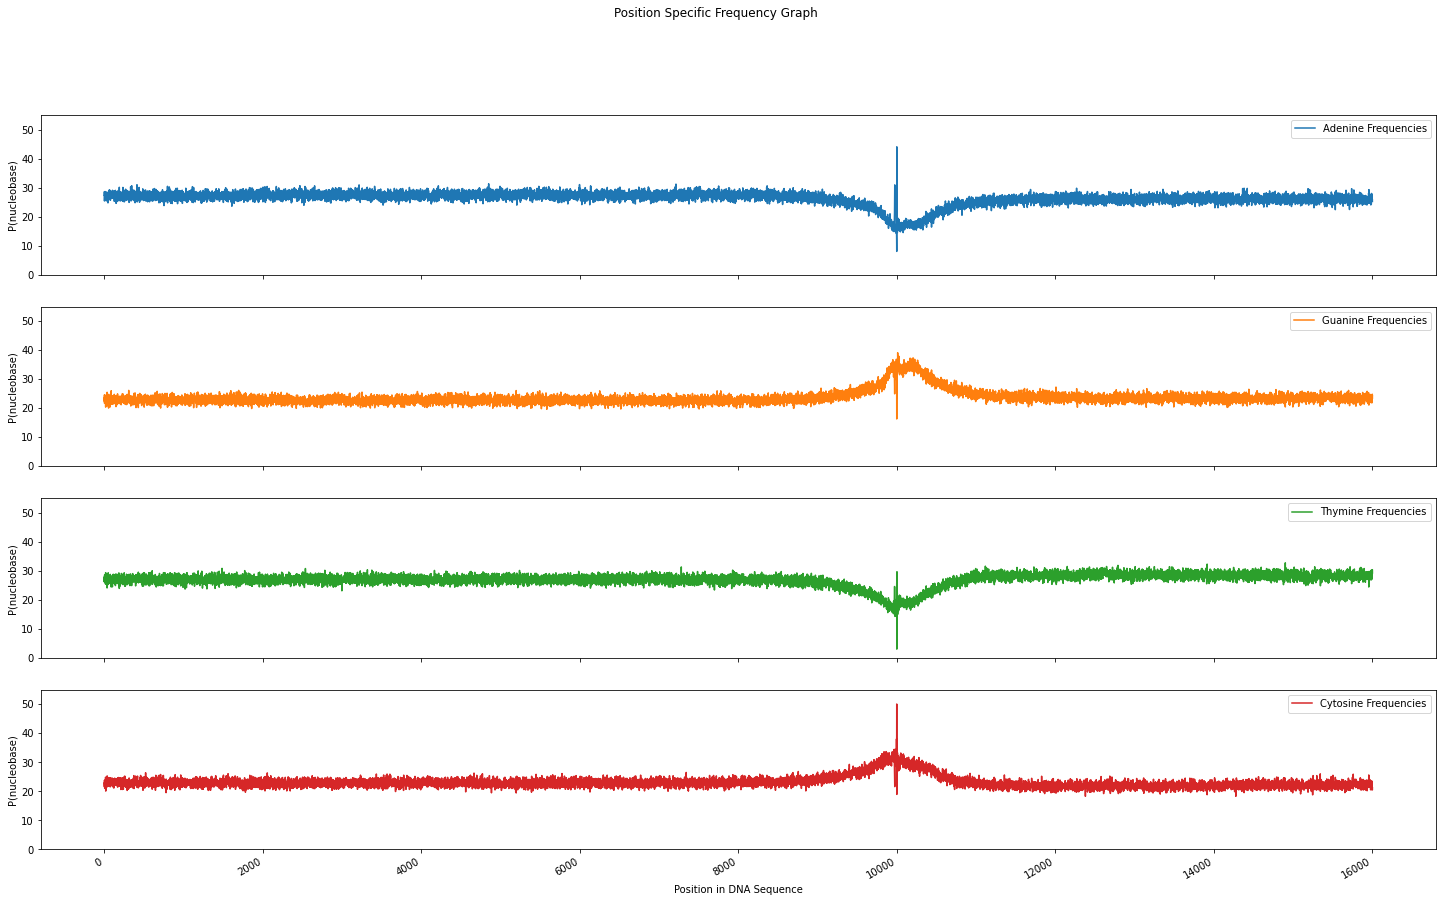

In [15]:
plt.figure()
frequency_df.plot(subplots=True, figsize=(25, 15), xlabel = "Position in DNA Sequence", ylabel = "P(nucleobase)", title = "Position Specific Frequency Graph", ylim = (0, 55))

# SUBSEQUENCE DATAFRAME INFORMATION

---



## Printing Subsequence DataFrame

In [16]:
subsequence_df.head(n=20)

,Sub-Sequences,Promoter-Index,SequenceStart,SequenceEnd
0,"(C, C, T, G, G, T, T, G, T, G, A, T, C, T, C, ...",3401,6599,12599
1,"(T, C, A, G, C, C, T, T, A, G, C, C, A, G, C, ...",1142,8858,14858
2,"(G, A, G, G, C, T, G, A, G, G, C, A, G, G, A, ...",2512,7488,13488
3,"(C, T, A, T, G, G, G, T, G, A, T, T, T, T, C, ...",4159,5841,11841
4,"(A, G, A, C, T, G, T, G, G, A, G, T, T, G, G, ...",3296,6704,12704
5,"(T, T, T, C, T, C, C, A, C, A, G, C, A, C, T, ...",2936,7064,13064
6,"(C, C, T, A, C, C, A, G, T, G, C, C, A, T, G, ...",3366,6634,12634
7,"(C, G, G, A, A, G, G, A, T, T, A, C, A, T, G, ...",1653,8347,14347
8,"(C, A, A, T, G, T, G, A, T, A, A, A, A, A, G, ...",2918,7082,13082
9,"(C, A, T, T, C, A, G, G, G, A, G, A, A, A, T, ...",4412,5588,11588


## Describing the subsequence dataframe

In [17]:
print('Index frequencies:')
print(subsequence_df['Promoter-Index'].value_counts())

Index frequencies:
2757    5
2645    4
2944    3
2240    3
1270    3
       ..
1258    1
3309    1
1263    1
4582    1
4096    1
Name: Promoter-Index, Length: 1502, dtype: int64


# Histogram plot of subsequence dataframe

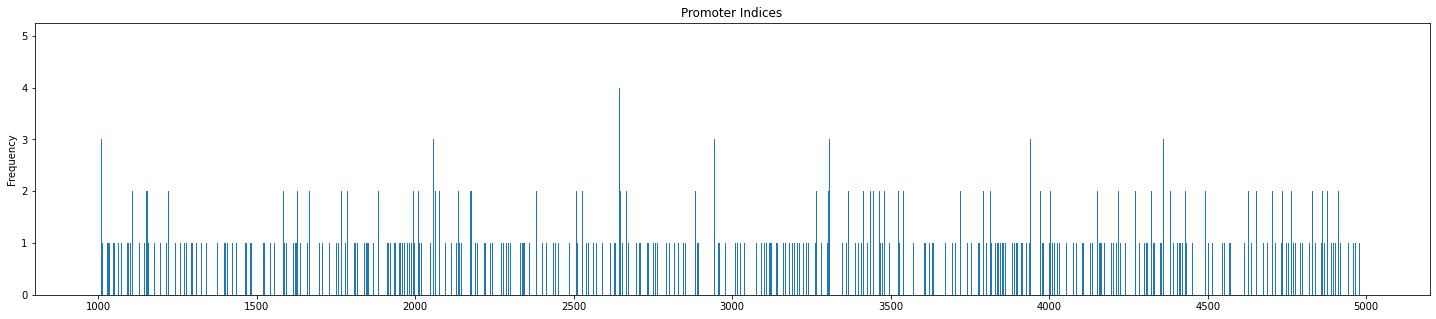

In [18]:
plt.figure()
subsequence_df['Promoter-Index'].plot.hist(histtype = 'bar', bins = 6000, figsize = (25, 5), title = 'Promoter Indices')

## Density plot of subsequence dataframe

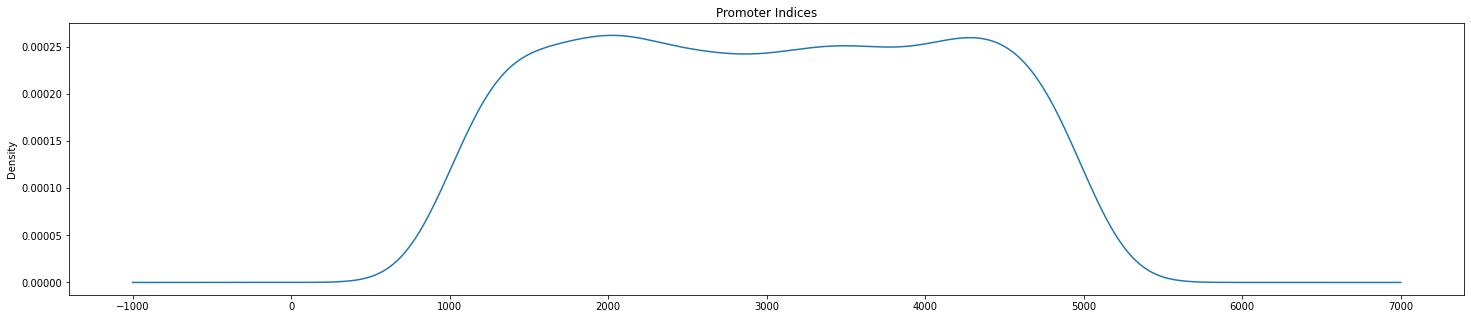

In [19]:
plt.figure()
subsequence_df['Promoter-Index'].plot.density(figsize = (25, 5), title = 'Promoter Indices')

## Arranging features and labels

In [20]:
X = dna_df.loc[:, 'Nuc-0' : 'Nuc-5999'].to_numpy()
y = dna_df.loc[:, 'Promoter-Index'].to_numpy()

print("Features: \n")
print(X)

print("Labels: \n")
print(y)

Features: 

[[0 0 1 ... 1 0 0]
 [0 1 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]]
Labels: 

[3401 1142 2512 ... 1342 2502 1297]


## PyTorch Dataset

In [21]:
import torch
from torch.utils.data import Dataset, random_split

class Sequences(Dataset):
    def __init__(self, X, y):
        self.sequences = torch.from_numpy(X) # convert numpy arrays to torch tensors
        self.labels = torch.from_numpy(y)

        self.sequences = self.sequences.unsqueeze(1) # add extra dimension for torch
        self.labels = self.labels.unsqueeze(1)

    def __len__(self):
        assert len(self.sequences) == len(self.labels) # ensure 1-to-1 correspondence
        return len(self.labels)

    def __getitem__(self, i):
        return self.sequences[i], self.labels[i] # return X, y pair

data = Sequences(X, y)
trainCount = int(0.8 * len(data)) # percent of our data for train
train, test = random_split(data, [trainCount, len(data) - trainCount])